<a href="https://colab.research.google.com/github/merillium/SD_homelessness_project/blob/master/sd_homeless_analysis_toggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Analysis of clustering in the San Diego homeless population

by Derek O'Connor, 11/26/19

#### The Research Question

In order to better understand the homelessness issue in downtown San Diego as well as improve outreach, we want to determine if the homeless population clusters around certain reference points (e.g. bus stops, parks, homeless shelters) with any statistical significance. 

We will be using the dataset provided by the 
[San Diego Regional Data Library](https://www.sandiegodata.org/2019/09/downtown-homeless-data-released/), which contains approximately 41,900 observations containing features: time stamps, temperature, and geographic location (geoid, latitude, longitude, neighborhood) of homeless people for 62 months between 2012 and 2018.

To determine if clustering around MTS bus stops occurs, we can use the dataset provided by the [San Diego MTS](https://www.sdmts.com/business-center/developers).


In [3]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [0]:
# first we install the required packages
!pip install geopandas 
!pip install ipyleaflet
!pip install git+https://github.com/python-visualization/folium
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shapely
import shapely.wkt
import random
import folium
from folium.plugins import HeatMap 
from folium.plugins import MarkerCluster
from google.colab import widgets
from google.colab import files
from shapely import geometry
from shapely.geometry import Point, Polygon, box
from math import sqrt, asin, sin, cos, atan2, radians, degrees
from math import ceil

In [0]:
# Importing relevant data files from SD_homeless_project repository: https://github.com/joddle/SD_homeless_project
# ... using pandas to import as dataframe, and converting to geopandas dataframe

# 3/16/20
# the following syntax is deprecated: crs={'init':'epsg:4326'}

# Homeless counts data originally downloaded from: http://library.metatab.org/sandiegodata.org-dowtown_homeless-1.csv
# homeless_df = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/sandiegodata.org-dowtown_homeless-1/data/homeless_counts.csv?raw=true')
# homeless_df = gpd.GeoDataFrame(homeless_df, crs={'init':'epsg:4326'})

homeless_df = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/sandiegodata.org-dowtown_homeless-8/data/homeless_counts.csv?raw=true')
homeless_df = gpd.GeoDataFrame(homeless_df)
homeless_df.crs = 'epsg:4326'

# MTS stop locations data originally downloaded from: https://www.sdmts.com/google_transit_files/google_transit.zip
mts_stops_df = pd.read_csv('https://raw.githubusercontent.com/joddle/SD_homeless_project/master/google_transit/stops.txt')

# mts_stops_df = gpd.GeoDataFrame(mts_stops_df, crs={'init':'epsg:4326'}, geometry=gpd.points_from_xy(mts_stops_df.stop_lon, mts_stops_df.stop_lat))
mts_stops_df = gpd.GeoDataFrame(mts_stops_df, geometry=gpd.points_from_xy(mts_stops_df.stop_lon, mts_stops_df.stop_lat))
mts_stops_df.crs = 'epsg:4326'

# imputed homeless counts data originally downloaded from: http://library.metatab.org/sandiegodata.org-dowtown_homeless-8.csv
homeless_imputed_df = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/sandiegodata.org-dowtown_homeless-8/data/imputed_counts.csv?raw=true')
homeless_imputed_df = gpd.GeoDataFrame(homeless_imputed_df)
homeless_imputed_df.crs = 'epsg:4326'

In [0]:
homeless_df.head()
# Data visualizations: Missing Data 

# a large percentage of temperature and rain data is missing 
homeless_df.info()
homeless_imputed_df.head()
homeless_imputed_df.info()
sns.heatmap(homeless_df.isnull(), cbar=False)

# determine if the location of missing values has correlation with any other variables
fig, ax = plt.subplots(figsize=(5,5))
msno.heatmap(homeless_df, ax=ax)

sns.heatmap(homeless_imputed_df.isnull(), cbar=False)
# determine if the location of missing values has correlation with any other variables
fig, ax = plt.subplots(figsize=(5,5))
msno.heatmap(homeless_imputed_df, ax=ax)

# clean up the column titles in mts_stops_df
mts_stops_df.head()
mts_stops_df = mts_stops_df[['stop_lon', 'stop_lat', 'geometry']]
mts_stops_df = mts_stops_df.rename(columns={'stop_lon': 'lon', 'stop_lat': 'lat'})

In [0]:
# We write a function taking in a reference gdf with 
# 'lat', 'lon', 'geometry' columns and returning a gdf
# with columns within the SD polygon specified in the function.
def get_ref_points_in_polygon(ref_df):
  # created a square polygon manually from http://apps.headwallphotonics.com/
  # to encompass downtown SD approximately (an exact polygon would be ideal)
  downtown_sd_polygon = Polygon([[-117.14498519897461, 32.72772530667563],
                            [-117.14469100989061, 32.70399523704015],
                            [-117.1773066715117, 32.70385078849076],
                            [-117.1773066715117, 32.72775384006868]])
  # type(downtown_sd_polygon)
  # print(downtown_sd_polygon.wkt)
  downtown_index = []
  for i in range(len(ref_df.index)):
    if downtown_sd_polygon.contains(ref_df['geometry'][i]):
      downtown_index.append(i)
  # print(downtown_index)
  downtown_ref_df = ref_df.iloc[downtown_index].reset_index(drop = True)
  return downtown_ref_df

In [0]:
downtown_mts_stops_df = get_ref_points_in_polygon(mts_stops_df)
downtown_mts_stops_df

In [0]:
# this function takes in a dataframe with a 'geometry' feature, extracts the latitude and longitude, 
# and outputs a df with ['lat', 'lon']  features as well as an array of ['lat', 'lon'] values 
# that can be parsed by the folium library to generate heatmaps
def getLatLonforHeatMap(homeless_df):
  homeless_polygon = homeless_df['geometry']
  homeless_polygon_list = []
  # polygon coordinates are strings and need to be parsed
  # convert str into polygon type and then find centroid of this polygon as a point
  for polygon in homeless_polygon:
    homeless_polygon_list.append(shapely.wkt.loads(polygon))
  homeless_points = [polygon.centroid for polygon in homeless_polygon_list]
  homeless_lat_lon = pd.DataFrame({'lon':[point.x for point in homeless_points], 'lat':[point.y for point in homeless_points], 'geometry': homeless_points})
  homeless_array = homeless_lat_lon[['lat', 'lon']].values
  return homeless_lat_lon, homeless_array

In [0]:
# Here we begin defining functions for a simulated data set of 
# how the homeless population could be distributed around the 
# reference points (MTS bus stops) assuming the relationship 
# between the observations and reference points has statistical signifiance.

# We define a function getPointsDF that creates a 
# dataframe containing only Point objects (latitude, longitude) 

def getPointsDF(homeless_df):
  homeless_polygon = homeless_df['geometry']
  homeless_polygon_list = []
  # polygon coordinates are strings and need to be parsed
  # convert str into polygon type and then find centroid of this polygon as a point
  for polygon in homeless_polygon:
    homeless_polygon_list.append(shapely.wkt.loads(polygon))
  homeless_points = [polygon.centroid for polygon in homeless_polygon_list]
  return pd.DataFrame({'Points': homeless_points})

In [0]:
homeless_points = getPointsDF(homeless_df)
homeless_points.head()

In [0]:
# Get lat/lon coordinates of homeless data
# homeless_polygon = homeless_df['geometry']
# type(homeless_polygon[0])

# polygon coordinates are strings and need to be parsed
# P = homeless_polygon[0]
# type(P)

# example: I want to convert a str into a polygon type
# ... and then find centroid of this polygon as a point
# P = shapely.wkt.loads('POLYGON ((51.0 3.0, 51.3 3.61, 51.3 3.0, 51.0 3.0))')
# print(P.centroid)

# type(homeless_polygon_list[0])

In [0]:
# Create map object with reference points
def make_ref_points_basemap(ref_points_df = downtown_mts_stops_df, default_loc = [32.7173, -117.1694], default_tiles = 'stamentoner', default_zoom = 13):
  ref_points_basemap = folium.Map(location = default_loc, tiles = default_tiles, zoom_start = default_zoom, control_scale = True)
  # add markers for the mts stations 
  for index, row in ref_points_df.iterrows():
    folium.CircleMarker([row['lat'], row['lon']],
                      radius = 1,
                      color = 'red',
                      fill_color = 'red',
                      ).add_to(ref_points_basemap)
  return ref_points_basemap

In [0]:
homeless_heatmap = make_ref_points_basemap()

# add the heatmap using the homeless array of lat/lon
# folium seems to have difficulty creating heatmaps for more than ~35,000 points

random.seed(42)
homeless_lat_lon_df, homeless_array = getLatLonforHeatMap(homeless_df)
homeless_array_subset = homeless_array[random.sample(range(0,len(homeless_array)), 35000)]

# heatmap = HeatMap(homeless_array).add_to(m)
homeless_heatmap.add_child(HeatMap(homeless_array_subset, radius=5))

# display heatmap
homeless_heatmap

Now we create a Folium heatmap of the distribution of the *observed* homeless population in downtown SD, with the locations of the MTS bus stops marked in red.

In [44]:
homeless_imputed_heatmap = make_ref_points_basemap()

# add the heatmap using the homeless array of lat/lon
# folium seems to have difficulty creating heatmaps for more than ~30,000 points

random.seed(42)
homeless_imputed_lat_lon_df, homeless_imputed_array = getLatLonforHeatMap(homeless_df)
homeless_imputed_array_subset = homeless_imputed_array[random.sample(range(0,len(homeless_imputed_array)), 35000)]

homeless_imputed_heatmap.add_child(HeatMap(homeless_imputed_array_subset, radius=5))

# display heatmap
homeless_imputed_heatmap

In [0]:
# in order to do statistical signifance testing we need a metric of spread of the data
# we will run a number of simulations and plot a histogram of the ANN (average nearest neighbors) value
# 
# Reference: https://mgimond.github.io/Spatial/hypothesis-testing.html#alternatives-to-csrirp

# helper functions for calculating haversine distance between two points (lat1, lat2), (lon1, lon2)
def haversine(angle_radians):
  return (sin(angle_radians / 2))**2
def get_haversine_dist(lat1, lon1, lat2, lon2):
  lat1, lat2 = radians(lat1), radians(lat2)
  lon1, lon2 = radians(lon1), radians(lon2)
  radius_earth = 6.371*pow(10,6)
  return 2*radius_earth*asin(sqrt(haversine(lat2 - lat1) + cos(lat1)*cos(lat2)*haversine(lon2 - lon1)))

In [0]:
# This function generates a simulated observation point around a reference point.
# 
# ... given a starting latitude and longitude, bearing angle (in units of DEGREES),
# as well as distance (in units of METERS)
# this function generates the ending latitude and longitude (in degrees)
# using the following formula (which has input and output in units of RADIANS)
# φ2 = asin(sin φ1 ⋅ cos δ + cos φ1 ⋅ sin δ ⋅ cos θ )
# λ2 = λ1 + atan2(sin θ ⋅ sin δ ⋅ cos φ1, cos δ − sin φ1 ⋅ sin φ2)
# where	φ is latitude, λ is longitude, θ is the bearing (clockwise from north), 
# δ is the angular distance d/R; d being the distance travelled, R the earth’s radius
# Reference: https://www.movable-type.co.uk/scripts/latlong.html

def generateNewPoint(lat1, lon1, distance, bearing):
  lat1 = radians(lat1)
  lon1 = radians(lon1)
  bearing = radians(bearing)
  radius_Earth = 6.371*pow(10,6)
  angular_dist = distance / radius_Earth
  lat2 = asin(sin(lat1) * cos(angular_dist) + cos(lat1) * sin(angular_dist) * cos(bearing))
  lon2 = lon1 + atan2(sin(bearing) * sin(angular_dist) * cos(lon1), cos(angular_dist) - sin(lat1) * sin(lat2))
  return degrees(lat2), degrees(lon2)
  

In [0]:
# We test that the above function works by generating equally spaced points around a reference point. 
# It appears as an ellipse on the map but is circular in reality due to the distorted projection of the map. 

# Note: mercator projection is distorted which is why a sequence of points the same distance from the starting point 
# appear to form an ellipse when in reality it is close to being a circle 
# (on the earth's curved plane which is essentially flat for such short distances)
testmap = make_ref_points_basemap(default_zoom = 16)
lat_start, lon_start = downtown_mts_stops_df['lat'][0], downtown_mts_stops_df['lon'][0]
folium.CircleMarker([lat_start, lon_start],
                      radius = 1,
                      color = 'blue',
                      fill_color = 'blue',
                      ).add_to(testmap)
for bearing in range(0, 360, 4):
  lat_end, lon_end = generateNewPoint(lat_start, lon_start, 400, bearing)
  folium.CircleMarker([lat_end, lon_end],
                      radius = 1,
                      color = 'green',
                      fill_color = 'green',
                      ).add_to(testmap)
testmap


In [0]:
# the following function calculates the approximate population density of each reference point
# relative to the observed points by looping through each reference point, 
# counting the number of observations within an upper_dist of the reference point
# then dividing through by the total number of observations counted
# NOTE: this does not account for population overlap...
# ... but we will consider the effect negligible on getting approximate densities for the reference points
def get_ref_densities(ref_points_df, points_df, upper_dist = 400):
  ref_points_counts = []
  for index, ref_row in ref_points_df.iterrows():
    count = 0
    for index, obs_row in points_df.iterrows():
      if get_haversine_dist(ref_row['lat'], ref_row['lon'], obs_row['lat'], obs_row['lon']) <= upper_dist:
        count = count + 1
    ref_points_counts.append(count)
  total_obs = sum(ref_points_counts)
  ref_density_list = [ref_points_count / total_obs for ref_points_count in ref_points_counts]
  ref_points_densities = pd.DataFrame({'density': ref_density_list})
  return pd.concat([ref_points_df, ref_points_densities], axis=1)

In [0]:
ref_points_df = get_ref_densities(downtown_mts_stops_df, homeless_lat_lon_df)

In [0]:
# ref_points_densities['density'] * 1000

In [0]:
# ref_points_densities.to_csv('ref_points_densities.csv')
# files.download('ref_points_densities.csv')

In [0]:
ref_points_density_df = pd.read_csv('https://raw.githubusercontent.com/joddle/SD_homeless_project/master/ref_points_densities.csv')
ref_points_density_df = ref_points_density_df[['lon', 'lat', 'geometry', 'density']]
ref_points_density_df.head()


We generate simulated points around each reference point, in this case MTS bus stops. There are some assumptions that can be fine-tuned: (1) the observations distance from each reference point is normally distributed (more points closer to the reference point, fewer points further away), (2) the number of points to be simulated around each reference point follows the percentage (density) of observations around each reference point. 

In [0]:
# this function takes in a ref_points_df that more points are to be generated around
# in the MTS stops research, we will generate points with radii normally distributed around each MTS stop
# ... there will be an argument to check whether each point is within the border of interest (in this case downtown SD)

# since the normal distribution represents the distance from the center of each stop
# it should be centered at 0 with a standard deviation that contains most of the data

# taking a 5-minute walk from each bus stop to be approximately 400 meters, 
# we expect 400 meters to be the distance most homeless people would be from each stop
# therefore we set 400 meters = 2 standard deviations or 95% of the observed data points, making the std_dev = 200

# the argument upper_distance will be 2 standard deviations so sigma = max_distance / 2

# the number of points simulated around each stop approximately matches the density of the homeless population found around the stops
# as calculated from the get_ref_densities function
# each reference point's relative density is multiplied by the total_points to determine 
# the number of simulated points (rounded up to the nearest integer) to be generated around each reference point 
def get_simulated_points(ref_points_density_df = ref_points_density_df, border = None, total_points = 10000, upper_dist = 400):
  mu, sigma = 0, upper_dist / 2.0
  lats_list = []
  lons_list = []
  random.seed(411)
  for index, row in ref_points_density_df.iterrows():
    number_of_points = int(ceil(total_points * row['density']))
    radii_rand = np.random.normal(mu, sigma, number_of_points)
    bearings_rand = 360.0 * np.random.ranf(number_of_points)
    for j in range(number_of_points):
      lat_new, lon_new = generateNewPoint(row['lat'], row['lon'], radii_rand[j], bearings_rand[j])
      lats_list.append(lat_new)
      lons_list.append(lon_new)
  return pd.DataFrame({'lat': lats_list, 'lon': lons_list})

Now we display the 10,000 *simulated* observations with a Folium heatmap that also shows the reference points. It makes sense that the clustering occurs around the reference points as this is a basic assumption built into our simulation. 

In [57]:
simulated_points_df = get_simulated_points(ref_points_density_df = ref_points_density_df, border = None, total_points = 10000, upper_dist = 400)
simulated_points_array = simulated_points_df[['lat', 'lon']].values
simulated_points_heatmap = make_ref_points_basemap()
simulated_points_heatmap.add_child(HeatMap(simulated_points_array, radius = 5))

In [0]:
simulated_points_df.head()

In [0]:
homeless_gpd = gpd.GeoDataFrame(homeless_lat_lon_df)
homeless_gpd.crs = 'epsg:4326'
homeless_gpd.head()

Now we need to do a statistical significance test to determine if the spread of the simulated data is similar to the spread of the observed data. 

To do this we calculate a statistic called average nearest neighbors (ANN). **Conceptually, the ANN measures the spread of a data set around reference points. **

![alt text](https://desktop.arcgis.com/en/arcmap/latest/tools/spatial-statistics-toolbox/GUID-0832339E-408F-40CF-B4E0-9FA57664F30F-web.png)
Source: [ArcGIS](https://desktop.arcgis.com/en/arcmap/latest/tools/spatial-statistics-toolbox/h-how-average-nearest-neighbor-distance-spatial-st.htm)

Applied to our problem: we find D₀ by calculating the cumulative distance between an observation and all of the bus stops, divide by the number of stops, then finding the sum of all of these average distances for every single point, and divide by the number of points. 

This value is then divided by DE.



In [0]:
(min_lon, min_lat, max_lon, max_lat) = homeless_gpd['geometry'].total_bounds
lat_dist = get_haversine_dist(min_lat, min_lon, max_lat, min_lon)
lon_dist = get_haversine_dist(min_lat, min_lon, min_lat, max_lon)
area = lat_dist * lon_dist
area

In [0]:
# get_haversine_dist(36.12, -86.67, 33.94, -118.40)
# generateNewPoint(36.12, -86.67, 10, 180)
# get_haversine_dist(36.12, -86.67, 36.119910067839406, -86.67)
# should come out to approximately 10 meters 

In [0]:
# this function takes in a series of points from a df, and returns the bounded rectangle area
# this is very much an approximation and is not the minimum bounding rectangle...
# ... however a larger rectangle will be returned for more spread out data in general 
# ... which is the reasoning behind dividing through by the rectangle's area in the ANN equation

# this oversimplification of the bounding rectangle area is strongly influenced by the presence of any outliers 
# this bounding rectangle also is strongly influenced by the shape of the data 
# (e.g. sideways elongated ellipse can have a much larger rectangle area than if we use the minimum bounding rectangle)

# check to make sure 'Points' column exists
def get_bounded_rect(points_df):
  if('Points' not in points_df.columns.values):
    print('No \'Points\' column in dataframe')
    print('Creating \'Points\' column from \'lat\' and \'lon\' columns...')
    homeless_gpd = gpd.GeoDataFrame(points_df, crs={'init':'epsg:4326'}, geometry = gpd.points_from_xy(points_df.lon, points_df.lat))
  else:
    homeless_gpd = gpd.GeoDataFrame(points_df, crs={'init':'epsg:4326'})
    homeless_gpd.rename(columns={'Points': 'geometry'}, inplace = True) 
  (min_lon, min_lat, max_lon, max_lat) = homeless_gpd['geometry'].total_bounds
  lat_dist = get_haversine_dist(min_lat, min_lon, max_lat, min_lon)
  lon_dist = get_haversine_dist(min_lat, min_lon, min_lat, max_lon)
  return lat_dist * lon_dist

In [0]:
# the following function takes a df of points and calculates the average nearest neighbors 
# from the df of points to each of the points in the df ref_pts (mts stops in this case)
# ... this metric is given by the average of the haversine distances between each observation and all reference points
# ANN ratio = D(O) / D(E) where D(O) is the mean of the sum of distances between each feature and its nearest neighbor
# ... and D(E) is the expected mean distance for features given by 0.5 / sqrt(n/A) 

# D(E) = 0.5 / sqrt(n/A) 
# where n is the total number of observations and A is the area of the minimum enclosing rectangle around the points

# The minimum bounding rectangle for the observed points *could* be significantly smaller 
# than the minimum bounding rectangle for the simulated points... so this should 
# make the ANN values more "relative" to each other and therefore comparable 

def get_ANN(points_df, ref_points_df):
  sum_NN = 0
  start = time.time()
  for one_index, one_row in points_df.iterrows():
    for other_index, other_row in ref_points_df.iterrows():
      sum_NN = sum_NN + get_haversine_dist(one_row['lat'], one_row['lon'], other_row['lat'], other_row['lon'])
    if one_index % 1000 == 0:
      end = time.time()
      print('Calculated ANN for point', one_index, 'of', len(points_df.index), 'in', end - start, 'seconds')
  mean_dist_obs = sum_NN / len(points_df.index)
  mean_dist_exp = 0.5 / sqrt(len(points_df.index) / get_bounded_rect(points_df))
  return mean_dist_obs / mean_dist_exp

In [0]:
def get_simulated_ANNs(ref_points_df, number_of_cycles = 100, points_per_ref = 5):
  simulated_ANNs = []
  for cycle in range(number_of_cycles):
    start = time.time()
    simulated_points_df = get_simulated_points(border = None, total_points = 10000, upper_dist = 400)
    simulated_ANNs.append(get_ANN(simulated_points_df, ref_points_df))
    end = time.time()
    print('finished simulation', cycle+1, 'in', end - start, 'seconds')
  return simulated_ANNs

In [0]:
simulated_points_df.head()

In [0]:
get_ANN(points_df = simulated_points_df[1:100], ref_points_df = downtown_mts_stops_df)

In [0]:
simulated_ANNs = get_simulated_ANNs(ref_points_df = downtown_mts_stops_df, number_of_cycles = 100, points_per_ref = 30)

In [0]:
def plot_simulated_ANNs_and_observed_ANN(simulated_ANNs, observed_ANN):
  simulated_points_array = np.asarray(simulated_ANNs)
  # if all simulated points smaller than observed, a broken axis can be helpful:
  if simulated_ANNs['ANNs'].all() < observed_ANN:
    fig, (ax,ax2) = plt.subplots(1, 2, figsize = (15,10), sharey = True, facecolor = 'w')
    fig.suptitle('Histogram of ANN for simulated homeless around mts stops', fontsize = 16)
    fig.text(0.5, 0.04, 'ANN value [measure of spread, unitless]', ha='center', fontsize = 14)
    fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical', fontsize = 14)

    ax.hist(simulated_points_array)
    ax2.axvline(x = observed_ANN, color = 'red')
    ymin, ymax = ax.get_ylim()
    plt.text(observed_ANN + 10.0, ymax / 2, 'observed ANN', rotation=90)

    ax.set_xlim(simulated_ANNs['ANNs'].min(), simulated_ANNs['ANNs'].max())
    ax.set_ylim(bottom = 0)
    ax.get_yaxis().set_visible(True)
    ax2.set_xlim(observed_ANN - 1000, observed_ANN + 1000)
    ax2.set_ylim(bottom = 0)
    
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.tick_params(labelright = 'off')

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform = ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d,1+d), (-d,+d), **kwargs)
    ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    ax2.plot((-d,+d), (-d,+d), **kwargs)
  else:
    plt.hist(simulated_points_array)
    plt.title('Histogram of ANN for simulated homeless around mts stops')
    plt.xlabel('ANN')
    plt.ylabel('Count')
  plt.show()

In [0]:
# Download the simulated ANNs
# simulated_ANNs_df = pd.DataFrame({'ANNs': simulated_ANNs})
# simulated_ANNs_df.to_csv('simulated_ANNs.csv')
# files.download('simulated_ANNs.csv')

In [67]:
# reupload the simulated_ANNs
simulated_ANNs = pd.read_csv('https://github.com/joddle/SD_homeless_project/blob/master/simulated_ANNs.csv?raw=true', index_col = [0])
simulated_ANNs.head()

,ANNs
0,11346.165606
1,11849.827259
2,11233.256941
3,11351.446486
4,11020.980770


In [0]:
observed_ANN = get_ANN(homeless_lat_lon_df, downtown_mts_stops_df)

We calculate the ANN of 100 simulations of the distribution of the homeless population, assuming clustering around bus stops. Then we calculate the observed ANN to see if this falls within a statistically significant level of the distribution of simulated ANNs.

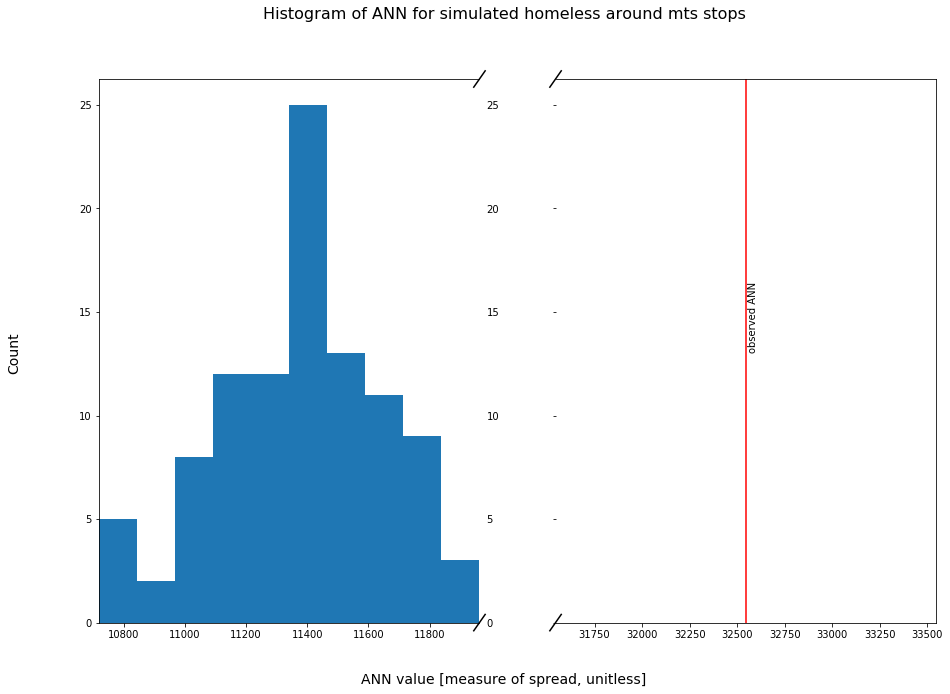

In [69]:
plot_simulated_ANNs_and_observed_ANN(simulated_ANNs, observed_ANN)


**Conclusion**: The ANN of the actual homeless population (observed) shows a much higher spread than the simulated ANN values. This indicates that the homeless population does not gather around MTS bus stops at a statistically significant level. 

In [0]:
files.download('simulated_vs_observed_ANN.png')

In [0]:
### The final part of the project: redo the same analysis but with park stops in downtown SD:

# Park locations data originally downloaded from: http://seshat.datasd.org/sde/parks/parks_datasd.zip
files.upload()

In [0]:
parks_sd = gpd.read_file("parks_datasd.shp", crs={'init':'epsg:4326'})
parks_sd.head()

In [0]:
parks_sd['geometry'] = parks_sd['geometry'].centroid
parks_sd = parks_sd.to_crs({'init': 'epsg:4326'})

In [0]:
parks_sd.head()

In [0]:
parks_downtown_sd = get_ref_points_in_polygon(parks_sd)

In [0]:
parks_downtown_sd

In [0]:
parks_downtown_sd['lon'] = parks_downtown_sd['geometry'].x
parks_downtown_sd['lat'] = parks_downtown_sd['geometry'].y

In [0]:
parks_downtown_sd = parks_downtown_sd[['lon', 'lat', 'geometry']]

In [0]:
homeless_parks_heatmap = make_ref_points_basemap(ref_points_df = parks_downtown_sd)
random.seed(4)
homeless_lat_lon_df, homeless_array = getLatLonforHeatMap(homeless_df)
homeless_array_subset = homeless_array[random.sample(range(0,len(homeless_array)), 35000)]

# heatmap = HeatMap(homeless_array).add_to(m)
homeless_parks_heatmap.add_child(HeatMap(homeless_array_subset, radius=5))

# display heatmap
homeless_parks_heatmap

In [0]:
# get reference point densities for simulation
sd_park_density_df = get_ref_densities(parks_downtown_sd, homeless_lat_lon_df)

In [0]:
sd_park_density_df

In [0]:
simulated_parks_points_df = get_simulated_points(ref_points_density_df = sd_park_density_df, border = None, total_points = 10000, upper_dist = 400)
simulated_parks_points_array = simulated_parks_points_df[['lat', 'lon']].values
simulated_parks_points_heatmap = make_ref_points_basemap()
simulated_parks_points_heatmap.add_child(HeatMap(simulated_parks_points_array, radius = 5))

In [0]:
simulated_ANNs = get_simulated_ANNs(ref_points_df = sd_park_density_df, number_of_cycles = 100, points_per_ref = 30)

In [0]:
observed_ANN = get_ANN(homeless_lat_lon_df, sd_park_density_df)

In [0]:
# plot_simulated_ANNs_and_observed_ANN(simulated_ANNs, observed_ANN)

In [0]:
observed_ANN

1740.3668742422867

In [0]:
simulated_ANNs

In [0]:
parks_downtown_sd.head()

In [0]:
mts_stops_df.head()

A more detailed project description is located at the [Github Respository](https://github.com/merillium/SD_homelessness_project)